In [ ]:
### REMEMBER THAT THIS PRETRAINED MODEL DOESN'T HAVE THE SAME ARCHITECTURE AS THE BASELINE UNET, ITS MUCH MORE COMPLEX AS ITS IN THE LEADERBOARDS OF THE BRAIN CHALLENGE AND AS IT WAS TRAINED ON 32 GPUs
## Still, it might be interesting to compare performances


In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt 

reconstruction_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/PretrainedUNet/reconstructions/'
GT_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_test_full/'
file = 'file_brain_AXFLAIR_200_6002441.h5'

GT_path = os.path.join(GT_path,file)
reconstruction_path = os.path.join(reconstruction_path,file)

GT = h5py.File(GT_path)
reconstruction = h5py.File(reconstruction_path)


In [11]:
GT = GT['reconstruction_rss']
reconstruction = reconstruction['reconstruction']


In [12]:
GT = np.array(GT)
reconstruction = np.array(reconstruction)
reconstruction = reconstruction[:,0,:,:]


In [13]:
slice = 3


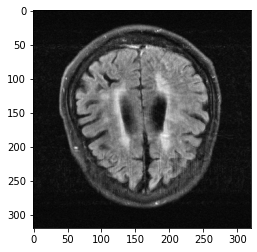

In [14]:
plt.imshow(GT[slice,:,:],cmap='gray')


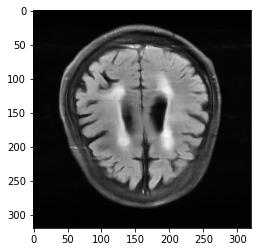

In [15]:
plt.imshow(reconstruction[slice,:,:],cmap='gray')
